Option(S0: 100, K: 100, premium: 0.5, is_put: False)
-0.5
Option(S0: 100, K: 110, premium: 0.3, is_put: True)
9.7
Option(S0: 100, K: 90, premium: 0.8, is_put: False)
9.2


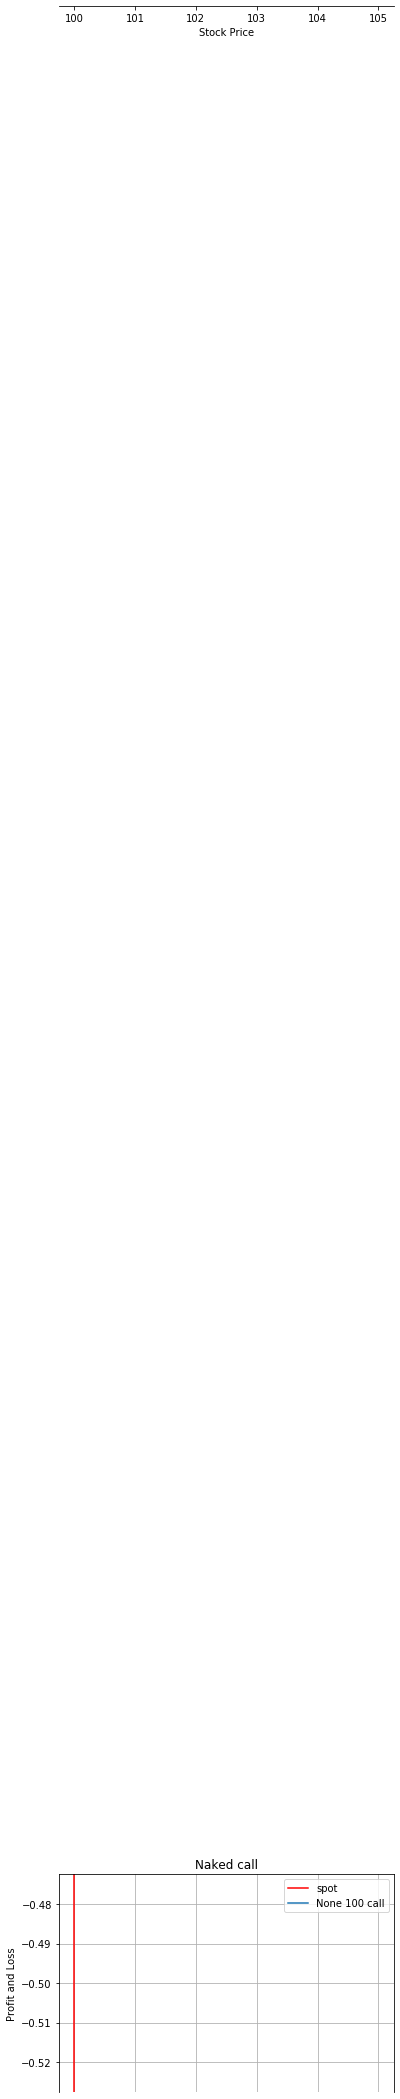

In [1]:
# payoff.py

import numpy as np
import matplotlib.pyplot as plt

class Payoff(object):
    def __init__(self, S0, K, premium, is_put=False):
        self.S0 = S0# stock price
        self.K = K# strike price
        self.premium = premium# current value
        self.is_put = is_put # put or call

    def __repr__(self):
#         print("Going thru __repr__")
        return 'Option(S0: {}, K: {}, premium: {}, is_put: {})'.format(self.S0, self.K, self.premium, self.is_put)

    def __str__(self):
#         print("Going thru __str__")
        return 'Option(S0: {}, K: {}, premium: {}, is_put: {})'.format(self.S0, self.K, self.premium, self.is_put)
    
    def calculate_payoff(self, position=None, sT=None):
        """ 
        sT is a range of possible stock prices
        to help us visualize option payoffs
        """
        # return a set of payoffs given a range of S0 prices
        self.position = position 
        
        if isinstance(sT,np.ndarray):
            if not self.is_put:
                payoff = np.where(sT > self.K, sT - self.K, 0) - self.premium
                self.payoff = payoff
                if self.position == 'short':
                    self.payoff = -payoff
                return self.payoff
            else:
                payoff = np.where(sT < self.K,  self.K - sT, 0) - self.premium
                self.payoff = payoff
                if self.position == 'short':
                    self.payoff = -payoff
                return self.payoff

        # return current payoffs given the current S0 price 
        else:# DEFAULT
            if not self.is_put: # DEFAULT. if it's a call option
                payoff = max(self.S0 - self.K, 0) - self.premium
                self.payoff = payoff 
                if position == 'short':
                    self.payoff = -payoff
                return self.payoff
            else: # if it's a put option
                payoff = max(self.K - self.S0, 0) - self.premium
                self.payoff = payoff 
                if position == 'short':
                    self.payoff = -payoff
                return self.payoff
    
    def current_payoff(self):
        if not self.is_put: # DEFAULT, call option
            payoff = max(self.S0 - self.K, 0) - self.premium
            if self.position == 'short':
                payoff = -payoff
            return payoff
        else:
            payoff = max(self.K - self.S0, 0) - self.premium
            if self.position == 'short':
                payoff = -payoff
            return payoff
            
    def visualize(self, sT):
        _, ax = plt.subplots()
        ax.spines['bottom'].set_position('zero')
        ax.axvline(self.S0, label='spot',color='r')
        ax.plot(sT,self.payoff,label='{} {} {}'.format(self.position, self.K, 'put' if self.is_put else 'call'))

        plt.title('Naked {}'.format('put' if self.is_put else 'call'))
        plt.xlabel('Stock Price')
        plt.ylabel('Profit and Loss')
        plt.legend()
        plt.grid()
        plt.show()

if __name__ == '__main__':
    sT = np.array([105])
    stock1 = Payoff(100, 100, 0.5, False)
    stock2 = Payoff(100, 110, 0.3, True)
    stock3 = Payoff(100, 90, 0.8, False)
    print(stock1)
    print(stock1.calculate_payoff())
    print(stock2)
    print(stock2.calculate_payoff())
    print(stock3)
    print(stock3.calculate_payoff())
    stock1.visualize(sT)

In [2]:
# Binomial_CRR.py

import numpy as np
import math

class Option(object):
    """S0 = 229.24 # spot price
        r = 0.001 # interest rate
        T = 28/365 # time to matuity 
        N: number of time steps
        div: dividend
        # num_contract = 1
    """
    def __init__(self, S0, K, r=0.00, T=1, N=2, pu=0, pd=0, div=0, sigma=0, is_put=False, is_am=False):
        self.S0 = S0
        self.K = K
        self.r = r
        self.T = T
        self.N = max(1,N)
        self.STs = [] # Declare the stock price tree
        self.is_am = is_am
        self.is_put = is_put

        # optial parameters
        self.pu, self.pd = pu, pd
        self.div = div
        self.sigma = sigma

    @property
    def dt(self):
        """single time step, in years"""
        return self.T/float(self.N)

    @property 
    def df(self):
        """the discount factor"""
        return math.exp(-(self.r-self.div)*self.dt)

class Binomial(Option):
    
    def setup_parameters(self):
        self.M = self.N + 1
        self.u = 1 + self.pu
        self.d = 1 - self.pd
        self.qu = (math.exp((self.r - self.div)* self.dt) - self.d)/ (self.u - self.d)
        self.qd = 1 - self.qu 

    def init_stock_price_tree(self):
        # Initialize a 2D tree at T=0
        self.STs = [np.array([self.S0])]

        # simulate the possible stock prices path
        for _ in range(self.N):
            prev_branches = self.STs[-1]
            st = np.concatenate(
                (prev_branches*self.u,
                    [prev_branches[-1]*self.d]))
            self.STs.append(st) # add nodes at each time step

    def init_payoffs_tree(self):
        if not self.is_put:
            return np.maximum(0, self.STs[self.N]-self.K)
        else:
            return np.maximum(0, self.K-self.STs[self.N])
    
    def check_early_exercise(self, payoffs, node):
        if not self.is_put:
            return np.maximum(payoffs, self.STs[node] - self.K)
        else:
            return np.maximum(payoffs, self.K - self.STs[node])
    
    def traverse_tree(self, payoffs):
        for i in reversed(range(self.N)):
            # not exercising options
            payoffs = (payoffs[:-1] * self.qu +
                        payoffs[1:]*self.qd) * self.df

            # payoffs from exercising American options
            if self.is_am:
                payoffs = self.check_early_exercise(payoffs, i)
        
        return payoffs

    def begin_tree_traversal (self):
        payoffs = self.init_payoffs_tree()
        return self.traverse_tree(payoffs)

    def price(self):
        self.setup_parameters()
        self.init_stock_price_tree()
        payoffs = self.begin_tree_traversal()
        return payoffs[0]

class CRR(Binomial):
    def setup_parameters(self):
        self.u = math.exp(self.sigma * math.sqrt(self.dt))
        self.d = 1./self.u
        self.qu = (math.exp((self.r - self.div) * self.dt) -
                    self.d) / (self.u - self.d)
        self.qd = 1 - self.qu

if __name__ == '__main__':
    long_put = Binomial(50, 52, r =0, T=2, N=2, pu=0.2, pd=0.2, is_put=True, is_am=True).price()
    eu_put = CRR(50, 52, r =0.05, T=2, N=2, sigma=0.3, is_put=True).price()
    print(long_put)
    print(eu_put)

7.0
6.245708445206436


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from payoff import Payoff
from Binomial_CRR import CRR

class Strategy(object):
    def __init__(self, S0, r, T, N, div, sT, model, is_am, transaction_cost=0.65):
        self.S0 = S0
        self.r = r
        self.N = N
        self.T = T
        self.div = div
        self.sT = sT
        self.model = model 
        self.is_am = is_am
        self.transaction_cost = transaction_cost

    def _option(self, K, sigma, is_put, position=None):
        pass

    def delta(self, K, sigma, is_put, num_contract=1, position='long'):
        option_forward = self.model(self.S0+1, K, r=self.r, T=self.T, N=self.N, div=self.div, sigma=sigma, is_put=is_put, is_am=self.is_am).price()
        option_backward = self.model(self.S0-1, K, r=self.r, T=self.T, N=self.N, div=self.div, sigma=sigma, is_put=is_put, is_am=self.is_am).price() 
        delta = (option_forward-option_backward)/2
        if position == 'long':
            return float(delta) * 100 * num_contract
        else: 
            return -1. * float(delta) * 100 * num_contract

    def gamma(self, K, sigma, is_put, num_contract=1, position='long'):
        option = self.model(self.S0, K, r=self.r, T=self.T, N=self.N, div=self.div, sigma=sigma, is_put=is_put, is_am=self.is_am).price()
        # option_forward = self.model(self.S0+1, K, r=self.r, T=self.T, N=self.N, sigma=sigma, is_put=is_put, is_am=self.is_am).price()
        # option_backward = self.model(self.S0-1, K, r=self.r, T=self.T, N=self.N, sigma=sigma, is_put=is_put, is_am=self.is_am).price()
        option_forward = self.model(self.S0+2, K, r=self.r, T=self.T, N=self.N, div=self.div, sigma=sigma, is_put=is_put, is_am=self.is_am).price()
        option_backward = self.model(self.S0-2, K, r=self.r, T=self.T, N=self.N, div=self.div, sigma=sigma, is_put=is_put, is_am=self.is_am).price() 
        delta_foward = (option_forward-option)/2
        delta_backward = (option-option_backward)/2
        gamma = (delta_foward-delta_backward)/2
        
        if position == 'long':
            return float(gamma) * 100 * num_contract
        else: 
            return -1. * float(gamma) * 100 * num_contract
    
    def theta(self, K, sigma, is_put, num_contract=1, position='long'):
        option_forward = self.model(self.S0, K, r=self.r, T=self.T-1/365, N=self.N-1, div=self.div, sigma=sigma, is_put=is_put, is_am=self.is_am).price()
        option_backward = self.model(self.S0, K, r=self.r, T=self.T+1/365, N=self.N+1, div=self.div, sigma=sigma, is_put=is_put, is_am=self.is_am).price() 
        theta = (option_forward-option_backward)/2

        if position == 'long':
            return float(theta) * 100 * num_contract
        else:
            return -1. * float(theta) * 100 * num_contract

    def vega(self, K, sigma, is_put, num_contract=1, position='long'):
        option_forward = self.model(self.S0, K, r=self.r, T=self.T, N=self.N, div=self.div, sigma=sigma+0.01, is_put=is_put, is_am=self.is_am).price()
        option_backward = self.model(self.S0, K, r=self.r, T=self.T, N=self.N, div=self.div, sigma=sigma-0.01, is_put=is_put, is_am=self.is_am).price() 
        theta = (option_forward-option_backward)/2
       
        if position == 'long':
            return float(theta) * 100 * num_contract
        else: 
            return -1. * float(theta) * 100 * num_contract

    def rho(self, K, sigma, is_put, num_contract=1, position='long'):
        option_forward = self.model(self.S0, K, r=self.r+0.01, T=self.T, N=self.N, div=self.div, sigma=sigma, is_put=is_put, is_am=self.is_am).price()
        option_backward = self.model(self.S0, K, r=self.r-0.01, T=self.T, N=self.N, div=self.div, sigma=sigma, is_put=is_put, is_am=self.is_am).price() 
        theta = (option_forward-option_backward)/2
        if position == 'long':
            return float(theta) * 100 * num_contract
        else:
            return -1. * float(theta) * 100 * num_contract

    def naked_call(self, K, sigma, position, num_contract=1):
        premium = self.model(self.S0, K, r=self.r, T=self.T, N=self.N, div=self.div, sigma=sigma, is_put=False, is_am=self.is_am).price()
        
        call = Payoff(self.S0, K, premium, is_put=False)
        payoff = ((call.calculate_payoff(position, self.sT) * 100) - self.transaction_cost) * num_contract
        current_payoff = (call.current_payoff() * 100 - self.transaction_cost) * num_contract

        print('# {} {} Call:'.format(position.title(), K), call)
        print('-- Delta:', round(self.delta(K, sigma, False, num_contract, position), 4))
        print('-- Gamma:', round(self.gamma(K, sigma, False, num_contract, position), 4))
        print('-- Theta:', round(self.theta(K, sigma, False, num_contract, position), 4))
        print('-- Vega:', round(self.vega(K, sigma, False, num_contract, position), 4))
        print('-- Rho:', round(self.rho(K, sigma, False, num_contract, position), 4))
        print('-- Profit and Loss:', round(current_payoff, 4))
        print('\n')

        _, ax = plt.subplots()
        ax.spines['bottom'].set_position('zero')
        ax.axvline(self.S0, label='spot',color='r')
        ax.plot(self.sT, payoff,label='{} {} call'.format(position, K))

        plt.title('Naked Call')
        plt.xlabel('Stock Price')
        plt.ylabel('Profit and Loss')
        plt.legend()
        plt.grid()
        plt.show()

        return current_payoff

    def naked_put(self, K, sigma, position, num_contract=1):
        premium = self.model(self.S0, K, r=self.r, T=self.T, N=self.N, div=self.div, sigma=sigma, is_put=True, is_am=self.is_am).price()
        
        put = Payoff(self.S0, K, premium, is_put=True)
        payoff = (put.calculate_payoff(position, self.sT) * 100 - self.transaction_cost) * num_contract
        current_payoff = (put.current_payoff() * 100 - self.transaction_cost) * num_contract

        print('# {} {} Put:'.format(position.title(), K), put)
        print('-- Delta:', round(self.delta(K, sigma, False, num_contract, position), 4))
        print('-- Gamma:', round(self.gamma(K, sigma, False, num_contract, position), 4))
        print('-- Theta:', round(self.theta(K, sigma, False, num_contract, position), 4))
        print('-- Vega:', round(self.vega(K, sigma, False, num_contract, position), 4))
        print('-- Rho:', round(self.rho(K, sigma, False, num_contract, position), 4))
        print('-- Profit and Loss:', round(current_payoff, 4))
        print('\n')
        
        _, ax = plt.subplots()
        ax.spines['bottom'].set_position('zero')
        ax.axvline(self.S0, label='spot',color='r')
        ax.plot(self.sT, payoff,label='{} {} put'.format(position, K))

        plt.title('Naked Call')
        plt.xlabel('Stock Price')
        plt.ylabel('Profit and Loss')
        plt.legend()
        plt.grid()
        plt.show()

        return current_payoff
        
    def iron_condor(self, strikes, sigmas, num_contract=1):
        #long call
        premium_long_call = self.model(self.S0, strikes[0], r=self.r, T=self.T, N=self.N, div=self.div, sigma=sigmas[0], is_put=False, is_am=self.is_am).price()
        long_call = Payoff(self.S0, strikes[0], premium_long_call, is_put=False)
        long_call_payoff = (long_call.calculate_payoff('long', self.sT) * 100 - self.transaction_cost) * num_contract 

        #short call
        premium_short_call = self.model(self.S0, strikes[1], r=self.r, T=self.T, N=self.N, div=self.div, sigma=sigmas[1], is_put=False, is_am=self.is_am).price()
        short_call = Payoff(self.S0, strikes[1], premium_short_call, is_put=False)
        short_call_payoff = (short_call.calculate_payoff('short', self.sT) * 100 - self.transaction_cost) * num_contract

        #long put 
        premium_long_put = self.model(self.S0, strikes[2], r=self.r, T=self.T, N=self.N, div=self.div, sigma=sigmas[2], is_put=True, is_am=self.is_am).price()
        long_put = Payoff(self.S0, strikes[2], premium_long_put, is_put=True)
        long_put_payoff = (long_put.calculate_payoff('long',self.sT) * 100 - self.transaction_cost) * num_contract

        #short put 
        premium_short_put = self.model(self.S0, strikes[3], r=self.r, T=self.T, N=self.N, div=self.div, sigma=sigmas[3], is_put=True, is_am=self.is_am).price()
        short_put = Payoff(self.S0, strikes[3], premium_short_put, is_put=True)
        short_put_payoff = (short_put.calculate_payoff('short',self.sT) * 100 - self.transaction_cost) * num_contract

        #Iron Condor 
        payoff = long_call_payoff + short_call_payoff + long_put_payoff + short_put_payoff
        current_payoff = ((long_call.current_payoff() + short_call.current_payoff() + long_put.current_payoff() + short_put.current_payoff()) * 100 - 4 * self.transaction_cost) * num_contract

        print('# Iron Condor Strategy:')
        print('-- Long {} Call:'.format(strikes[0]), long_call)
        print('-- Short {} Call:'.format(strikes[1]), short_call)
        print('-- Long {} Put:'.format(strikes[2]), long_put)
        print('-- Short {} Put:'.format(strikes[3]), short_put)
        print('-- Delta:', round(self.delta(strikes[0], sigmas[0], False, num_contract) + self.delta(strikes[1], sigmas[1], False, num_contract, 'short') + self.delta(strikes[2], sigmas[2], True, num_contract) + self.delta(strikes[3], sigmas[3], True, num_contract, 'short'), 4))
        print('-- Gamma:', round(self.gamma(strikes[0], sigmas[0], False, num_contract) + self.gamma(strikes[1], sigmas[1], False, num_contract, 'short') + self.gamma(strikes[2], sigmas[2], True, num_contract) + self.gamma(strikes[3], sigmas[3], True, num_contract, 'short'), 4))
        print('-- Theta:', round(self.theta(strikes[0], sigmas[0], False, num_contract) + self.theta(strikes[1], sigmas[1], False, num_contract, 'short') + self.theta(strikes[2], sigmas[2], True, num_contract) + self.theta(strikes[3], sigmas[3], True, num_contract, 'short'), 4))
        print('-- Vega:', round(self.vega(strikes[0], sigmas[0], False, num_contract) + self.vega(strikes[1], sigmas[1], False, num_contract, 'short') + self.vega(strikes[2], sigmas[2], True, num_contract) + self.vega(strikes[3], sigmas[3], True, num_contract, 'short'), 4))
        print('-- Rho:', round(self.rho(strikes[0], sigmas[0], False, num_contract) + self.rho(strikes[1], sigmas[1], False, num_contract, 'short') + self.rho(strikes[2], sigmas[2], True, num_contract) + self.rho(strikes[3], sigmas[3], True, num_contract, 'short'), 4))
        print('-- Profit and Loss:', round(current_payoff, 4))
        print('\n')

        _, ax = plt.subplots()
        ax.spines['bottom'].set_position('zero')
        ax.plot(self.sT,long_call_payoff,'--',label='Long Call',color='g')
        ax.plot(self.sT,short_call_payoff,'--',label='Short Call',color='r')
        ax.plot(self.sT,long_put_payoff,'--',label='Long Put',color='y')
        ax.plot(self.sT,short_put_payoff,'--',label='Short Put',color='m')
        ax.plot(self.sT,payoff,label='Iron Condor')

        plt.title('Iron Condor Strategy')
        plt.xlabel('Stock Price')
        plt.ylabel('Profit and loss')
        plt.legend()
        plt.grid()

        plt.show()
        return current_payoff

    def call_spread(self, strikes, sigmas, num_contract=1):
        #long call
        premium_long_call = self.model(self.S0, strikes[0], r=self.r, T=self.T, N=self.N, sigma=sigmas[0], is_put=False, is_am=self.is_am).price()
        long_call = Payoff(self.S0, strikes[0], premium_long_call, is_put=False)
        long_call_payoff = (long_call.calculate_payoff('long', self.sT) * 100 - self.transaction_cost) * num_contract

        #short call
        premium_short_call = self.model(self.S0, strikes[1], r=self.r, T=self.T, N=self.N, sigma=sigmas[1], is_put=False, is_am=self.is_am).price()
        short_call = Payoff(self.S0, strikes[1], premium_short_call, is_put=False)
        short_call_payoff = (short_call.calculate_payoff('short', self.sT) * 100 - self.transaction_cost) * num_contract

        #call spread 
        payoff = long_call_payoff + short_call_payoff
        current_payoff = ((long_call.current_payoff() + short_call.current_payoff()) * 100 - 2 * self.transaction_cost) * num_contract

        print('# {} Call Spread Strategy:'.format('Bull' if strikes[0] < strikes[1] else 'Bear'))
        print('-- Long {} Call:'.format(strikes[0]), long_call)
        print('-- Short {} Call:'.format(strikes[1]), short_call)
        print('-- Delta:', round(self.delta(strikes[0], sigmas[0], False, num_contract) + self.delta(strikes[1], sigmas[1], False, num_contract, 'short'), 4))
        print('-- Gamma:', round(self.gamma(strikes[0], sigmas[0], False, num_contract) + self.gamma(strikes[1], sigmas[1], False, num_contract, 'short'), 4))
        print('-- Theta:', round(self.theta(strikes[0], sigmas[0], False, num_contract) + self.theta(strikes[1], sigmas[1], False, num_contract, 'short'), 4))
        print('-- Vega:', round(self.vega(strikes[0], sigmas[0], False, num_contract) + self.vega(strikes[1], sigmas[1], False, num_contract, 'short'), 4))
        print('-- Rho:', round(self.rho(strikes[0], sigmas[0], False, num_contract) + self.rho(strikes[1], sigmas[1], False, num_contract, 'short'), 4))
        print('-- Profit and Loss:', round(current_payoff, 4))
        print('\n')

        _, ax = plt.subplots()
        ax.spines['bottom'].set_position('zero')
        ax.plot(self.sT,long_call_payoff,'--',label='Long Call',color='g')
        ax.plot(self.sT,short_call_payoff,'--',label='Short Call',color='r')
        ax.plot(self.sT,payoff,label='{} Call Spread'.format('Bull' if strikes[0] < strikes[1] else 'Bear'))

        plt.title('{} Call Spread Strategy'.format('Bull' if strikes[0] < strikes[1] else 'Bear'))
        plt.xlabel('Stock Price')
        plt.ylabel('Profit and loss')
        plt.legend()
        plt.grid()

        plt.show()
        return current_payoff

    def put_spread(self, strikes, sigmas, num_contract=1):
        #long put 
        premium_long_put = self.model(self.S0, strikes[0], r=self.r, T=self.T, N=self.N, sigma=sigmas[0], is_put=True, is_am=self.is_am).price()
        long_put = Payoff(self.S0, strikes[0], premium_long_put, is_put=True)
        long_put_payoff = (long_put.calculate_payoff('long',self.sT) * 100 - self.transaction_cost) * num_contract

        #short put 
        premium_short_put = self.model(self.S0, strikes[1], r=self.r, T=self.T, N=self.N, sigma=sigmas[1], is_put=True, is_am=self.is_am).price()
        short_put = Payoff(self.S0, strikes[1], premium_short_put, is_put=True)
        short_put_payoff = (short_put.calculate_payoff('short',self.sT) * 100 - self.transaction_cost) * num_contract

        #put spread 
        payoff = long_put_payoff + short_put_payoff
        current_payoff = ((long_put.current_payoff() + short_put.current_payoff()) * 100 - 2 * self.transaction_cost) * num_contract

        print('# {} Put Spread Strategy'.format('Bull' if strikes[0] < strikes[1] else 'Bear'))
        print('-- Long {} Put:'.format(strikes[0]), long_put)
        print('-- Short {} Put:'.format(strikes[1]), short_put)
        print('-- Delta:', round(self.delta(strikes[0], sigmas[0], True, num_contract) + self.delta(strikes[1], sigmas[1], True, num_contract, 'short'), 4))
        print('-- Gamma:', round(self.gamma(strikes[0], sigmas[0], True, num_contract) + self.gamma(strikes[1], sigmas[1], True, num_contract, 'short'), 4))
        print('-- Theta:', round(self.theta(strikes[0], sigmas[0], True, num_contract) + self.theta(strikes[1], sigmas[1], True, num_contract, 'short'), 4))
        print('-- Vega:', round(self.vega(strikes[0], sigmas[0], True, num_contract) + self.vega(strikes[1], sigmas[1], True, num_contract, 'short'), 4))
        print('-- Rho:', round(self.rho(strikes[0], sigmas[0], True, num_contract) + self.rho(strikes[1], sigmas[1], True, num_contract, 'short'), 4))
        print('-- Profit and Loss', round(current_payoff, 4))
        print('\n')

        _, ax = plt.subplots()
        ax.spines['bottom'].set_position('zero')
        ax.plot(self.sT,long_put_payoff,'--',label='Long Put',color='g')
        ax.plot(self.sT,short_put_payoff,'--',label='Short Put',color='r')
        ax.plot(self.sT,payoff,label='{} Put Spread'.format('Bull' if strikes[0] < strikes[1] else 'Bear'))

        plt.title('{} Put Spread Strategy'.format('Bull' if strikes[0] < strikes[1] else 'Bear'))
        plt.xlabel('Stock Price')
        plt.ylabel('Profit and loss')
        plt.legend()
        plt.grid()

        plt.show()
        return current_payoff

    def long_straddle(self, strikes, sigmas, num_contract=1):
        #long call
        premium_long_call = self.model(self.S0, strikes[0], r=self.r, T=self.T, N=self.N, div=self.div, sigma=sigmas[0], is_put=False, is_am=True).price()
        long_call = Payoff(self.S0, strikes[0], premium_long_call, is_put=False)
        long_call_payoff = (long_call.calculate_payoff('long', self.sT) * 100 - self.transaction_cost) * num_contract

        #long put 
        premium_long_put = self.model(self.S0, strikes[1], r=self.r, T=self.T, N=self.N, div=self.div, sigma=sigmas[1], is_put=True, is_am=True).price()
        long_put = Payoff(self.S0, strikes[1], premium_long_put, is_put=True)
        long_put_payoff = (long_put.calculate_payoff('long',self.sT) * 100 - self.transaction_cost) * num_contract

        #long straddle 
        payoff = long_call_payoff + long_put_payoff 
        current_payoff = ((long_call.current_payoff() + long_put.current_payoff()) * 100 - 2 * self.transaction_cost) * num_contract

        print('# Long Straddle Strategy' if strikes[0] == strikes[1] else '# Long Strangle')
        print('-- Long {} Call:'.format(strikes[0]), long_call)
        print('-- Long {} Put:'.format(strikes[1]), long_put)
        print('-- Delta:', round(self.delta(strikes[0], sigmas[0], False, num_contract) + self.delta(strikes[1], sigmas[1], True, num_contract), 4))
        print('-- Gamma:', round(self.gamma(strikes[0], sigmas[0], False, num_contract) + self.gamma(strikes[1], sigmas[1], True, num_contract), 4))
        print('-- Theta:', round(self.theta(strikes[0], sigmas[0], False, num_contract) + self.theta(strikes[1], sigmas[1], True, num_contract), 4))
        print('-- Vega:', round(self.vega(strikes[0], sigmas[0], False, num_contract) + self.vega(strikes[1], sigmas[1], True, num_contract), 4))
        print('-- Rho:', round(self.rho(strikes[0], sigmas[0], False, num_contract) + self.rho(strikes[1], sigmas[1], True, num_contract), 4))
        print('-- Profit and Loss:', round(current_payoff, 4))
        print('\n')

        _, ax = plt.subplots()
        ax.spines['bottom'].set_position('zero')
        ax.plot(self.sT,long_call_payoff,'--',label='Long Call',color='g')
        ax.plot(self.sT,long_put_payoff,'--',label='Long Put',color='r')
        ax.plot(self.sT,payoff,label='Long Straddle' if strikes[0] == strikes[1] else 'Long Strangle')

        plt.title('Long Straddle' if strikes[0] == strikes[1] else 'Long Strangle')
        plt.xlabel('Stock Price')
        plt.ylabel('Profit and loss')
        plt.legend()
        plt.grid()

        plt.show()
        return current_payoff

    def delta_hedge(self):
        pass

    def put_call_parity(self):
        pass
    

# Iron Condor Strategy:
-- Long 240 Call: Option(S0: 229.24, K: 240, premium: 14.160344958398374, is_put: False)
-- Short 245 Call: Option(S0: 229.24, K: 245, premium: 11.76601351130347, is_put: False)
-- Long 235 Put: Option(S0: 229.24, K: 235, premium: 21.686301146269997, is_put: True)
-- Short 230 Put: Option(S0: 229.24, K: 230, premium: 19.315230461359608, is_put: True)
-- Delta: 0.1271
-- Gamma: 0.0
-- Theta: -1.1681
-- Vega: 0.5413
-- Rho: -0.2633
-- Profit and Loss: 20.8598




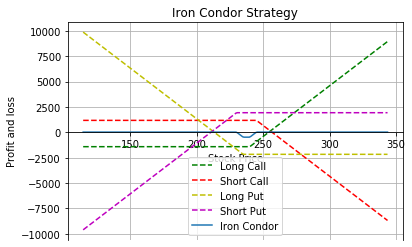

# Long 240 Call: Option(S0: 229.24, K: 240, premium: 14.160344958398374, is_put: False)
-- Delta: 45.109
-- Gamma: 0.8439
-- Theta: -33.1217
-- Vega: 25.1119
-- Rho: 6.6679
-- Profit and Loss: -1416.6845




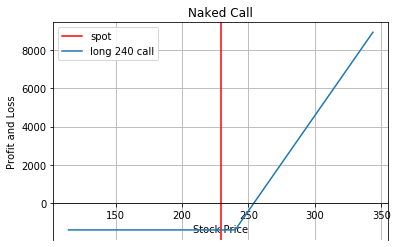

In [3]:
# main.py

import numpy as np 

from strategies import Strategy
from Binomial_CRR import CRR

S0 = 229.24 # spot price
r = 0.001 # interest rate
T = 28/365 # time to matuity 
N = 10000 # number of time steps
div = 0 # dividend
# num_contract = 1

#stock price range at the end of maturity 
sT = np.arange(0.5*S0, 1.5*S0, 1)

#strategy class initialize
strategy = Strategy(S0, r, T, N, div, sT = sT, model = CRR, is_am = True)

strike_long_call = 240
strike_short_call = 245
strike_long_put = 235
strike_short_put = 230

sigma_long_call = 0.7363
sigma_short_call = 0.7108
sigma_long_put = 0.7294
sigma_short_put = 0.7479

#iron condor
strikes_iron_condor = [strike_long_call, strike_short_call, strike_long_put, strike_short_put]
sigmas_iron_condor = [sigma_long_call, sigma_short_call, sigma_long_put, sigma_short_put]
iron_condor_payoff = strategy.iron_condor(strikes_iron_condor, sigmas_iron_condor)

# # call spread
# strikes_call_spread = [strike_long_call, strike_short_call]
# sigmas_call_spread = [sigma_long_call, sigma_short_call]
# call_spread_payoff = strategy.call_spread(strikes_call_spread, sigmas_call_spread)

# # put spread 
# strikes_put_spread = [strike_long_put, strike_short_put]
# sigmas_put_spread = [sigma_long_put, sigma_short_put]
# put_spread_payoff = strategy.put_spread(strikes_put_spread, sigmas_put_spread)

# # long straddle / strangle
# strikes_long_straddle = [strike_long_call, strike_long_put]
# sigmas_long_straddle = [sigma_long_call, sigma_long_put]
# long_straddle_payoff = strategy.long_straddle(strikes_long_straddle, sigmas_long_straddle)

# naked call / put
long_call_payoff = strategy.naked_call(strike_long_call, sigma_long_call, 'long')
# long_put_payoff = strategy.naked_put(strike_long_put, sigma_long_put, 'long')
# short_call_payoff = strategy.naked_call(strike_short_call, sigma_short_call, 'short')
# short_put_payoff = strategy.naked_put(strike_short_put, sigma_short_put, 'short')